# ML Model

## For English and Hindi Text

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F

# Load your dataset with the distances
df = pd.read_excel('ML_Project_main_hate_fake.xlsx')

# Load the previously saved embeddings
all_embeddings = torch.load("xlm-roberta_hindi_embeddings.pt")

# Extract the distances from the DataFrame
distances_hate = df['Distance_Hin_Hate'].values.reshape(-1, 1)
distances_fake = df['Distance_Hin_Fake'].values.reshape(-1, 1)

# Normalize distances using GELU activation
normalized_distances_hate = F.gelu(torch.tensor(distances_hate, dtype=torch.float))
normalized_distances_fake = F.gelu(torch.tensor(distances_fake, dtype=torch.float))

# Add normalized distances as new features to the embeddings
all_embeddings_with_normalized_distances = torch.cat([all_embeddings, normalized_distances_hate, normalized_distances_fake], dim=1)

# Save the modified embeddings with normalized distances as a PyTorch tensor
torch.save(all_embeddings_with_normalized_distances, "modified_xlm-roberta_hindi_embeddings_with_normalized_distances.pt")

print("Modified embeddings with normalized distances saved as modified_xlm-roberta_hindi_embeddings_with_normalized_distances.pt")

Modified embeddings with normalized distances saved as modified_xlm-roberta_hindi_embeddings_with_normalized_distances.pt


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset from your .xlsx file
input_file = "ML_Project_main_hate_fake.xlsx"
df = pd.read_excel(input_file)

# Load embeddings from "embeddings.pt"
all_embeddings = torch.load("modified_xlm-roberta_hindi_embeddings_with_normalized_distances.pt").numpy()  # Load with PyTorch and convert to NumPy array

# Prepare the labels
labels_fake = tf.convert_to_tensor(df['Fake'].values)
labels_hate = tf.convert_to_tensor(df['Hate'].values)

# Convert TensorFlow tensors to NumPy arrays
labels_fake = labels_fake.numpy()
labels_hate = labels_hate.numpy()

# Split the data into train and test sets
train_embeddings, test_embeddings, train_labels_fake, test_labels_fake, train_labels_hate, test_labels_hate = train_test_split(all_embeddings, labels_fake, labels_hate, test_size=0.2, random_state=42)


In [ ]:
all_embeddings.shape

(8014, 770)

1/1 [==============================] - 0s 22ms/step
Fake Detection Metrics - Epoch 1:
Accuracy: 0.5994
Precision: 0.9515
Recall: 0.2553
F1 Score: 0.4026

Hate Detection Metrics - Epoch 1:
Accuracy: 0.6488
Precision: 0.9145
Recall: 0.4941
F1 Score: 0.6416

1/1 [==============================] - 0s 29ms/step
Fake Detection Metrics - Epoch 2:
Accuracy: 0.6494
Precision: 0.9385
Recall: 0.3605
F1 Score: 0.5209

Hate Detection Metrics - Epoch 2:
Accuracy: 0.6981
Precision: 0.9496
Recall: 0.5550
F1 Score: 0.7006

1/1 [==============================] - 0s 23ms/step
Fake Detection Metrics - Epoch 3:
Accuracy: 0.6544
Precision: 0.9347
Recall: 0.3723
F1 Score: 0.5325

Hate Detection Metrics - Epoch 3:
Accuracy: 0.7100
Precision: 0.9648
Recall: 0.5648
F1 Score: 0.7125

1/1 [==============================] - 0s 20ms/step
Fake Detection Metrics - Epoch 4:
Accuracy: 0.6581
Precision: 0.9308
Recall: 0.3818
F1 Score: 0.5415

Hate Detection Metrics - Epoch 4:
Accuracy: 0.7238
Precision: 0.9816
Recall: 0

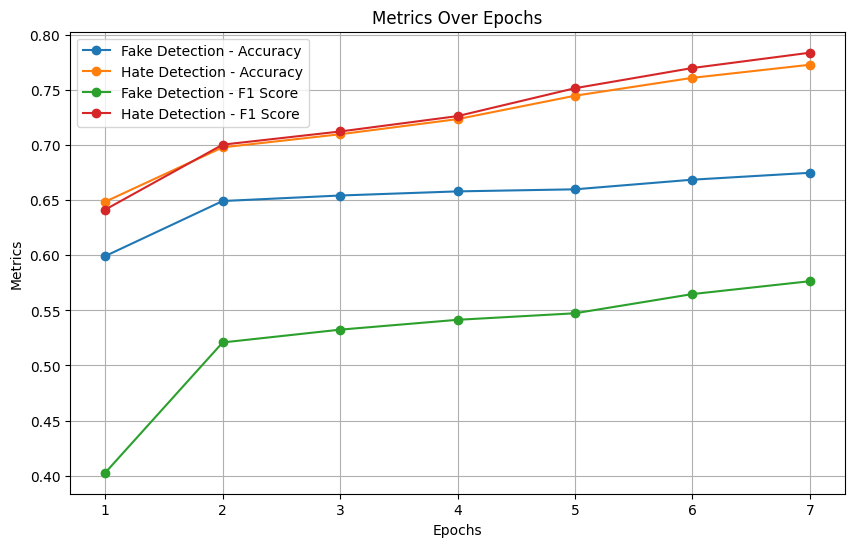

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Define a custom dataset
class MultiTaskDataset(tf.keras.utils.Sequence):
    def __init__(self, embeddings, labels_fake, labels_hate, batch_size):
        self.embeddings = embeddings
        self.labels_fake = labels_fake
        self.labels_hate = labels_hate
        self.batch_size = batch_size

    def __len__(self):
        return len(self.embeddings) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        return self.embeddings[start:end], self.labels_fake[start:end], self.labels_hate[start:end]

# Create data loaders for training and testing
batch_size = 32
train_dataset = MultiTaskDataset(train_embeddings, train_labels_fake, train_labels_hate, batch_size)
test_dataset = MultiTaskDataset(test_embeddings, test_labels_fake, test_labels_hate, batch_size)

# Define the multi-task classification model in TensorFlow
def create_multi_task_model(input_dim):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    fake_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    fake_output = tf.keras.layers.Dense(1)(fake_layer)

    hate_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    hate_output = tf.keras.layers.Dense(1)(hate_layer)

    model = tf.keras.models.Model(inputs=input_layer, outputs=[fake_output, hate_output])

    return model

model = create_multi_task_model(all_embeddings.shape[1])
# Compile the model with hinge loss
model.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy'])

# Initialize and train the multi-task model
num_epochs = 7

# Lists to store metrics for each epoch
accuracy_fake_list = []
f1_fake_list = []
accuracy_hate_list = []
f1_hate_list = []

max_f1_fake = 0  # Variable to store the highest F1-score for Fake
max_f1_hate = 0  # Variable to store the highest F1-score for Hate

best_epoch_fake = 0  # Variable to store the epoch with the highest F1-score for Fake
best_epoch_hate = 0  # Variable to store the epoch with the highest F1-score for Hate

# Modify the calculate_metrics function
def calculate_metrics(y_true, y_pred, task_name, epoch):
    y_pred = (np.array(y_pred) >= 0.5).astype(int)
    y_true = y_true[:len(y_pred)]  # Ensure consistent lengths

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{task_name} Metrics - Epoch {epoch + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    return accuracy, f1  # Return the metrics

for epoch in range(num_epochs):
    for batch in train_dataset:
        embeddings, labels_fake, labels_hate = batch
        model.train_on_batch(embeddings, [labels_fake, labels_hate])

    # Evaluation on the test set
    fake_preds, hate_preds = [], []
    for batch in test_dataset:
        embeddings, labels_fake, labels_hate = batch
        fake_pred, hate_pred = model.predict(embeddings)
        fake_preds.extend(fake_pred)
        hate_preds.extend(hate_pred)

    # Ensure consistent lengths of test labels and predictions
    min_length = min(len(test_labels_fake), len(fake_preds))
    test_labels_fake = test_labels_fake[:min_length]
    fake_preds_binary = (np.array(fake_preds)[:min_length] >= 0.5).astype(int)
    test_labels_hate = test_labels_hate[:min_length]
    hate_preds_binary = (np.array(hate_preds)[:min_length] >= 0.5).astype(int)

    # Calculate metrics for fake detection
    accuracy_fake, f1_fake = calculate_metrics(test_labels_fake, fake_preds_binary, "Fake Detection", epoch)
    accuracy_fake_list.append(accuracy_fake)
    f1_fake_list.append(f1_fake)

    # Calculate metrics for hate detection
    accuracy_hate, f1_hate = calculate_metrics(test_labels_hate, hate_preds_binary, "Hate Detection", epoch)
    accuracy_hate_list.append(accuracy_hate)
    f1_hate_list.append(f1_hate)

    # Update max_f1_fake and best_epoch_fake if a new high F1-score is achieved for Fake
    if f1_fake > max_f1_fake:
        max_f1_fake = f1_fake
        best_epoch_fake = epoch + 1

    # Update max_f1_hate and best_epoch_hate if a new high F1-score is achieved for Hate
    if f1_hate > max_f1_hate:
        max_f1_hate = f1_hate
        best_epoch_hate = epoch + 1

# Print the highest F1-scores and best epochs for Fake and Hate
print(f"Highest F1-Score for Fake: {max_f1_fake:.4f} at Epoch {best_epoch_fake}")
print(f"Highest F1-Score for Hate: {max_f1_hate:.4f} at Epoch {best_epoch_hate}")

# Display the classification report at the end
print("Classification Report - Fake Detection:")
print(classification_report(test_labels_fake, fake_preds_binary))

print("Classification Report - Hate Detection:")
print(classification_report(test_labels_hate, hate_preds_binary))

# Plotting the metrics
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

# Plotting Accuracy
plt.plot(epochs_range, accuracy_fake_list, label='Fake Detection - Accuracy', marker='o')
plt.plot(epochs_range, accuracy_hate_list, label='Hate Detection - Accuracy', marker='o')

# Plotting F1-score
plt.plot(epochs_range, f1_fake_list, label='Fake Detection - F1 Score', marker='o')
plt.plot(epochs_range, f1_hate_list, label='Hate Detection - F1 Score', marker='o')

plt.title('Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()
